In [ ]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# print("Contents:", os.listdir(path))

# # Correct subfolders
# cat_dir = os.path.join(path, "PetImages/Cat")
# dog_dir = os.path.join(path, "PetImages/Dog")

# print("Cat samples:", len(os.listdir(cat_dir)))
# print("Dog samples:", len(os.listdir(dog_dir)))

# # Step 2: Create clean dataset structure
# base_dir = "dataset"
# for split in ["train", "val", "test"]:
#     for category in ["Cat", "Dog"]:
#         os.makedirs(os.path.join(base_dir, split, category), exist_ok=True)

# cat_images = [os.path.join(cat_dir, f) for f in os.listdir(cat_dir)]
# dog_images = [os.path.join(dog_dir, f) for f in os.listdir(dog_dir)]

# # Train/Val/Test split
# train_cats, test_cats = train_test_split(cat_images, test_size=0.2, random_state=42)
# train_dogs, test_dogs = train_test_split(dog_images, test_size=0.2, random_state=42)

# val_cats, test_cats = train_test_split(test_cats, test_size=0.5, random_state=42)
# val_dogs, test_dogs = train_test_split(test_dogs, test_size=0.5, random_state=42)

# # Copy files into new structure
# def copy_files(file_list, target_dir):
#     for f in file_list:
#         try:
#             shutil.copy(f, target_dir)
#         except:
#             continue

# copy_files(train_cats, os.path.join(base_dir, "train/Cat"))
# copy_files(train_dogs, os.path.join(base_dir, "train/Dog"))
# copy_files(val_cats, os.path.join(base_dir, "val/Cat"))
# copy_files(val_dogs, os.path.join(base_dir, "val/Dog"))
# copy_files(test_cats, os.path.join(base_dir, "test/Cat"))
# copy_files(test_dogs, os.path.join(base_dir, "test/Dog"))

# print("✅ Reorganized dataset created!")

# # Step 3: Load images into feature vectors
# IMG_SIZE = 64

# def load_data(dataset_path):
#     data, labels = [], []
#     for category in ["Cat", "Dog"]:
#         folder = os.path.join(dataset_path, category)
#         label = 0 if category == "Cat" else 1
#         for file in os.listdir(folder):
#             img_path = os.path.join(folder, file)
#             try:
#                 img = cv2.imread(img_path)
#                 img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
#                 img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#                 img = img.flatten()
#                 data.append(img)
#                 labels.append(label)
#             except:
#                 continue
#     return np.array(data), np.array(labels)

# X_train, y_train = load_data(os.path.join(base_dir, "train"))
# X_val, y_val = load_data(os.path.join(base_dir, "val"))
# X_test, y_test = load_data(os.path.join(base_dir, "test"))

# print("Train:", X_train.shape, y_train.shape)
# print("Val:", X_val.shape, y_val.shape)
# print("Test:", X_test.shape, y_test.shape)

# # Step 4: Train SVM
# clf = SVC(kernel="linear")
# clf.fit(X_train, y_train)

# # Step 5: Evaluate
# val_acc = accuracy_score(y_val, clf.predict(X_val))
# test_acc = accuracy_score(y_test, clf.predict(X_test))
# print("Validation Accuracy:", val_acc)
# print("Test Accuracy:", test_acc)

# # Step 6: Prediction function
# def predict_image(img_path):
#     img = cv2.imread(img_path)
#     img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#     img = img.flatten().reshape(1, -1)
#     pred = clf.predict(img)[0]
#     return "🐱 Cat" if pred == 0 else "🐶 Dog"


In [1]:
# 🐶🐱 Cats vs Dogs Classification with Transfer Learning (MobileNetV2)
# Includes dataset cleaning + custom input testing

import tensorflow as tf
from tensorflow.keras import layers, models
import os, shutil, imghdr
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing import image
from google.colab import files

# -------------------------------
# 1. Dataset Path
# -------------------------------
path = "/kaggle/input/dog-and-cat-classification-dataset/PetImages"
cat_dir = os.path.join(path, "Cat")
dog_dir = os.path.join(path, "Dog")

# -------------------------------
# 2. Prepare train / val / test splits
# -------------------------------
base_dir = "/kaggle/working/dataset"
train_dir = os.path.join(base_dir, "train")
val_dir   = os.path.join(base_dir, "val")
test_dir  = os.path.join(base_dir, "test")

for folder in [train_dir, val_dir, test_dir]:
    os.makedirs(os.path.join(folder, "Cat"), exist_ok=True)
    os.makedirs(os.path.join(folder, "Dog"), exist_ok=True)

# Split Cat
cat_files = [os.path.join(cat_dir, f) for f in os.listdir(cat_dir) if f.endswith(".jpg")]
train_cat, test_cat = train_test_split(cat_files, test_size=0.2, random_state=42)
val_cat, test_cat = train_test_split(test_cat, test_size=0.5, random_state=42)

# Split Dog
dog_files = [os.path.join(dog_dir, f) for f in os.listdir(dog_dir) if f.endswith(".jpg")]
train_dog, test_dog = train_test_split(dog_files, test_size=0.2, random_state=42)
val_dog, test_dog = train_test_split(test_dog, test_size=0.5, random_state=42)

# Copy files
def copy_files(files, target_dir):
    for f in files:
        try:
            shutil.copy(f, target_dir)
        except:
            pass

copy_files(train_cat, os.path.join(train_dir, "Cat"))
copy_files(val_cat, os.path.join(val_dir, "Cat"))
copy_files(test_cat, os.path.join(test_dir, "Cat"))

copy_files(train_dog, os.path.join(train_dir, "Dog"))
copy_files(val_dog, os.path.join(val_dir, "Dog"))
copy_files(test_dog, os.path.join(test_dir, "Dog"))

print("✅ Dataset prepared!")

# -------------------------------
# 3. Clean corrupted files
# -------------------------------
def clean_dataset(folder):
    removed = 0
    for root, dirs, files in os.walk(folder):
        for f in files:
            file_path = os.path.join(root, f)
            try:
                img_type = imghdr.what(file_path)
                if img_type not in ["jpeg", "png"]:
                    os.remove(file_path)
                    removed += 1
            except:
                os.remove(file_path)
                removed += 1
    print(f"🧹 Cleaned {removed} invalid files from {folder}")

clean_dataset(train_dir)
clean_dataset(val_dir)
clean_dataset(test_dir)

# -------------------------------
# 4. Load Data
# -------------------------------
IMG_SIZE = (128, 128)
BATCH_SIZE = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir, image_size=IMG_SIZE, batch_size=BATCH_SIZE
).map(lambda x, y: (x/255.0, y))

val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir, image_size=IMG_SIZE, batch_size=BATCH_SIZE
).map(lambda x, y: (x/255.0, y))

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir, image_size=IMG_SIZE, batch_size=BATCH_SIZE
).map(lambda x, y: (x/255.0, y))

# -------------------------------
# 5. Build Transfer Learning Model
# -------------------------------
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(128,128,3),
    include_top=False,
    weights="imagenet"
)
base_model.trainable = False  # freeze base

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(1, activation="sigmoid")
])

model.compile(optimizer="adam",
              loss="binary_crossentropy",
              metrics=["accuracy"])

# -------------------------------
# 6. Train Model
# -------------------------------
history = model.fit(train_ds, validation_data=val_ds, epochs=5)

# -------------------------------
# 7. Evaluate
# -------------------------------
test_loss, test_acc = model.evaluate(test_ds)
print("🎯 Test Accuracy:", test_acc)

# -------------------------------
# 8. Custom Prediction on Uploaded Image
# -------------------------------
# uploaded = files.upload()

# for fname in uploaded.keys():
#     img_path = fname
#     img = image.load_img(img_path, target_size=IMG_SIZE)
#     img_array = image.img_to_array(img) / 255.0
#     img_array = np.expand_dims(img_array, axis=0)
    
#     prediction = model.predict(img_array)[0][0]
#     label = "Dog 🐶" if prediction > 0.5 else "Cat 🐱"
    
#     plt.imshow(img)
#     plt.title(f"Prediction: {label} ({prediction:.2f})")
    # plt.axis("off")
    # plt.show()


2025-09-14 15:05:13.370661: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757862313.618417      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757862313.685611      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/tmp/ipykernel_36/2767482249.py:6: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import os, shutil, imghdr


✅ Dataset prepared!
🧹 Cleaned 196 invalid files from /kaggle/working/dataset/train
🧹 Cleaned 33 invalid files from /kaggle/working/dataset/val
🧹 Cleaned 21 invalid files from /kaggle/working/dataset/test
Found 19802 files belonging to 2 classes.


I0000 00:00:1757862506.537862      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1757862506.538582      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Found 2467 files belonging to 2 classes.
Found 2479 files belonging to 2 classes.
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/5


I0000 00:00:1757862516.491168     106 service.cc:148] XLA service 0x7f6dac003910 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1757862516.492181     106 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1757862516.492203     106 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1757862517.402341     106 cuda_dnn.cc:529] Loaded cuDNN version 90300


 13/619 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.5388 - loss: 0.8799  

I0000 00:00:1757862520.973275     106 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 50/619 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.6973 - loss: 0.6141

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


126/619 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.7992 - loss: 0.4298

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


170/619 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.8250 - loss: 0.3794

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


245/619 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.8520 - loss: 0.3256

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


284/619 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.8618 - loss: 0.3062

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


308/619 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.8668 - loss: 0.2962

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


364/619 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.8765 - loss: 0.2767

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


408/619 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.8827 - loss: 0.2642

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


470/619 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.8900 - loss: 0.2494

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


568/619 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8988 - loss: 0.2314

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


608/619 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9018 - loss: 0.2253

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


619/619 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9026 - loss: 0.2238

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


619/619 ━━━━━━━━━━━━━━━━━━━━ 29s 29ms/step - accuracy: 0.9026 - loss: 0.2236 - val_accuracy: 0.9582 - val_loss: 0.0982
Epoch 2/5
 59/619 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.9593 - loss: 0.0892

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


132/619 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.9597 - loss: 0.0936

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


172/619 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.9600 - loss: 0.0944

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


246/619 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9607 - loss: 0.0948

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


272/619 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.9608 - loss: 0.0949

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


316/619 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.9611 - loss: 0.0949

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


352/619 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9613 - loss: 0.0948

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


424/619 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9617 - loss: 0.0942

440/619 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9618 - loss: 0.0941

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


475/619 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9620 - loss: 0.0938

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


567/619 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9623 - loss: 0.0932

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


607/619 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9625 - loss: 0.0930

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


616/619 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9625 - loss: 0.0930

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


619/619 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.9625 - loss: 0.0930 - val_accuracy: 0.9615 - val_loss: 0.0966
Epoch 3/5
 61/619 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.9629 - loss: 0.0898

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


132/619 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.9634 - loss: 0.0895

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


173/619 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.9638 - loss: 0.0891

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


247/619 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9643 - loss: 0.0894

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


275/619 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.9644 - loss: 0.0895

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


316/619 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.9646 - loss: 0.0895

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


368/619 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9648 - loss: 0.0894

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


412/619 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9650 - loss: 0.0891

428/619 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9651 - loss: 0.0890

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


492/619 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9654 - loss: 0.0885

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


583/619 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9656 - loss: 0.0882

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


610/619 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9657 - loss: 0.0882

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


614/619 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9657 - loss: 0.0882

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


619/619 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.9658 - loss: 0.0881 - val_accuracy: 0.9615 - val_loss: 0.0962
Epoch 4/5
 49/619 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.9691 - loss: 0.0770

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


127/619 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - accuracy: 0.9703 - loss: 0.0737

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


171/619 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.9699 - loss: 0.0748

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


247/619 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9692 - loss: 0.0771

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


280/619 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.9691 - loss: 0.0776

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


324/619 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.9690 - loss: 0.0781

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


350/619 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9690 - loss: 0.0783

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


412/619 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9691 - loss: 0.0783

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


471/619 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9692 - loss: 0.0784

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


571/619 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9691 - loss: 0.0789

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


607/619 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9690 - loss: 0.0791

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


615/619 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9690 - loss: 0.0791

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


619/619 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.9690 - loss: 0.0791 - val_accuracy: 0.9607 - val_loss: 0.0938
Epoch 5/5
 57/619 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.9715 - loss: 0.0662

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


127/619 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.9692 - loss: 0.0701

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


171/619 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.9689 - loss: 0.0714

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


265/619 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.9683 - loss: 0.0747

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


312/619 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.9681 - loss: 0.0757

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


348/619 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9681 - loss: 0.0763

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


410/619 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9682 - loss: 0.0767

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


479/619 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9683 - loss: 0.0770

Corrupt JPEG data: 214 extraneous bytes before marker 0xd9


572/619 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9684 - loss: 0.0775

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


603/619 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9684 - loss: 0.0776

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


616/619 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9684 - loss: 0.0776

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


619/619 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.9685 - loss: 0.0777 - val_accuracy: 0.9603 - val_loss: 0.0950
78/78 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.9694 - loss: 0.0847
🎯 Test Accuracy: 0.9689390659332275


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


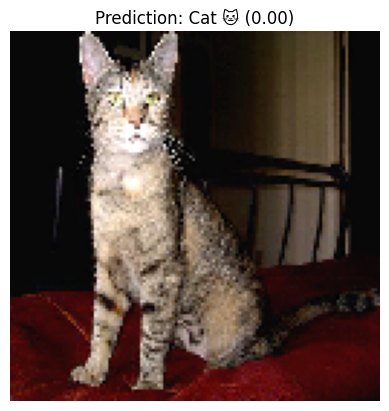

In [4]:
from google.colab import files
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# uploaded = files.upload()  # opens file chooser

# for fname in uploaded.keys():
#     img_path = fname
img_path='/kaggle/input/dog-and-cat-classification-dataset/PetImages/Cat/10000.jpg'
img = image.load_img(img_path, target_size=(128, 128))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

prediction = model.predict(img_array)[0][0]
label = "Dog 🐶" if prediction > 0.5 else "Cat 🐱"

plt.imshow(img)
plt.title(f"Prediction: {label} ({prediction:.2f})")
plt.axis("off")
plt.show()
